# Selective Capacitated Fair Pickup and Delivery Problem

In [99]:
from dataclasses import dataclass
import math
import matplotlib.pyplot as plt

## Defining an "Instance" class
we start by defining a "Instance" class that contains all the information we are given from an instance file. We can access the variables for each instance as attributes of our "Instance" class.

In [100]:
@dataclass
class Instance:
    def __init__(self, filename: str | None = None):
        if filename is not None:
            self.load_from_file(filename)

    @staticmethod # tell python this method doesn't depend on "self"
    def read_tuple(f):
        return tuple(map(int, f.readline().split()))

    def load_from_file(self, filename):
        with open(filename) as input_file:
            params_line = input_file.readline().split(" ")
            self.n = int(params_line[0])
            self.n_k = int(params_line[1])
            self.C = int(params_line[2])
            self.gamma = int(params_line[3])
            self.rho = float(params_line[4])
            _ = input_file.readline()
            demand_line = [int(c_i) for c_i in input_file.readline().split()]
            _ = input_file.readline()
            self.depot = self.read_tuple(input_file)
            self.requests = []
            self.requests_location_array = []
            for i in range(self.n):
                pick_up = self.read_tuple(input_file)
                request = {
                    "pick_up": pick_up,
                    "drop_off": None,
                    "demand": demand_line[i],
                    "index": i
                }
                self.requests.append(request)
                self.requests_location_array.append(pick_up)
            for i in range(self.n):
                drop_off = self.read_tuple(input_file)
                self.requests[i]["drop_off"] = drop_off
                self.requests_location_array.append(drop_off)
            if input_file.readline().strip() != "":# make sure we are at the end of the file and there's no more content
                raise ValueError("Unexpected extra content at end of file")

In [101]:
# testing how the class works
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
aaa = Instance()
aaa.load_from_file(filename)
aaa.depot

(35, 35)

In [102]:
aaa.requests[49]

{'pick_up': (43, 27), 'drop_off': (65, 67), 'demand': 24, 'index': 49}

## Helper Functions for evaluating the performance of our algorithm

In [103]:
# takes two tuples representing carthesian coordinates as input
def a(u, v):
    return math.ceil(math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2))

# takes the route as list of indices of request locations as input
def get_total_distance(instance, route):
    total_distance = 0
    current_location = instance.depot # we start at the depot
    for location_index in route:
        location_index = location_index - 1 # be careful with off-by-one errors!
        next_location = instance.requests_location_array[location_index]
        total_distance = total_distance + a(current_location, next_location)
        current_location = next_location
    total_distance = total_distance + a(current_location, instance.depot)
    return total_distance

# take a list of routes as input
def get_Jain_fairness(instance, routes):
    numerator = 0
    denominator = 0
    for route in routes:
        d = get_total_distance(instance, route)
        numerator = numerator + d
        denominator = denominator + d**2
    return numerator**2 / (instance.n_k * denominator) # I know it says n in the assignment but n_k makes more sense and its like that on wikipedia

def objective_function(instance, routes):
    value = 0
    for route in routes:
        value = value + get_total_distance(instance, route)
    value = value + instance.rho * (1 - get_Jain_fairness(instance, routes))
    return value


In [104]:
def is_legal_route():
    pass # TODO

## Naive approach
Let's try a naive approach first to understand the problem format and to set a baseline we can compare against later. What's the simplest approach we can solve this problem with?
* every vehicle just drives from the depot to the resuest pick up location, then to the request drop off location, serve n/2 requests and then go back to the depot
* each vehicle serves n/n_k requests
* save route as list of int indices in an array

if index 1 is the pick up location, index 1 + n is the drop of location
So a naive route with n=10 & n_k = 2 would look like this

1 11 2 12 3 13 4 14 5 15

6 16 7 17 8 18 9 19 10 20

In [105]:
def naive_algorithm(instance):
    routes = []
    i = 1
    for k in range(instance.n_k):
        R_k = []
        request_to_serve = math.ceil(instance.n/instance.n_k)
        for request in range(request_to_serve):
            if i <= 2*instance.n:
                R_k.append(i)
                R_k.append(i + instance.n)
            else:
                print("Already all requests served")
            i = i + 1
        routes.append(R_k)
    return routes

In [106]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
routes = naive_algorithm(instance)

In [110]:
get_total_distance(instance, routes[0])

1957

In [111]:
get_Jain_fairness(instance, routes)

0.9986053715747215

In [112]:
objective_function(instance, routes)

3773.036176661352

## Visualization
In order to get a better feeling what our algorithm is actually doing, here is a small visualization (Code generated with ChatGPT)

In [113]:
# this is GPT generated code to visualize how the vehicles are driving around
def plot_routes(instance, routes):
    plt.figure(figsize=(8, 8))
    plt.scatter(*instance.depot, c="black", marker="s", s=100, label="Depot")  # draw the depot

    for i, route in enumerate(routes):
        color = f"C{i % 10}"  # use matplotlib color cycle
        x_coords = [instance.depot[0]]
        y_coords = [instance.depot[1]]

        # add coordinates for each stop
        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            x_coords.append(loc[0])
            y_coords.append(loc[1])

        # return to depot
        x_coords.append(instance.depot[0])
        y_coords.append(instance.depot[1])

        # draw route line
        plt.plot(x_coords, y_coords, "-", color=color, label=f"Vehicle {i+1}")

        # mark pickups (▲) and drop-offs (▼)
        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            if idx <= instance.n:  # pickup
                plt.scatter(loc[0], loc[1], marker="^", color=color, s=70)
            else:  # drop-off
                plt.scatter(loc[0], loc[1], marker="v", color=color, s=70)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Routes")
    plt.legend()
    plt.axis("equal")
    plt.show()


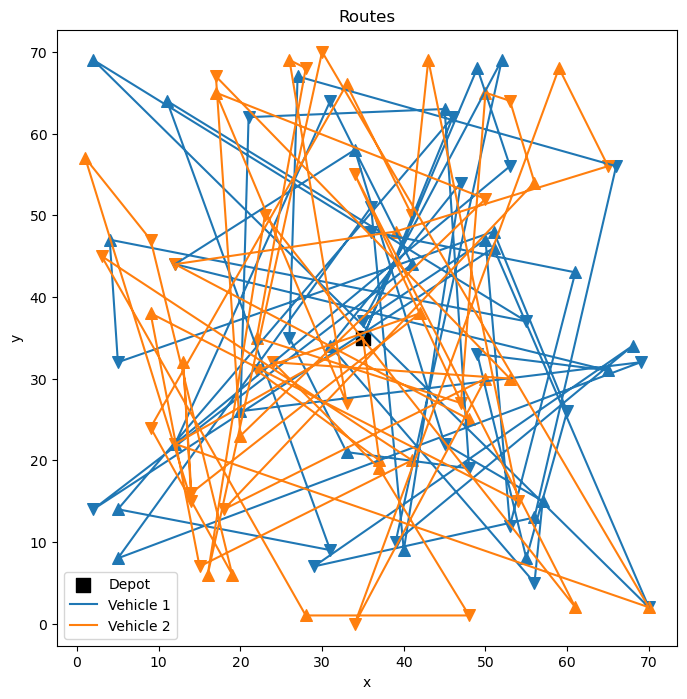

In [114]:
plot_routes(instance, routes)

## Subtask 1: Deterministic construction heuristic
For our first real subtask, we are asked to develop a meaningful construction heuristic. We chose to do so based on the Nearest Neighbor Heuristic, which means we start at an arbitrary node and always go to a nearest unvisited node. This seems like a reasonable choice.
We have to adapt this heuristic a little bit to match our specific problem, i.e. we have to take into account that we have multiple vehicles and we only need to satisfy gamma requests. So:
```
For each vehicle:
    - we look at the nearest pick up location
    - if we still have enough capacity, we go there and pick it up
    - if not, we go to the nearest drop of location
    - repeat until we have gamma requests done
```

<s>But apparently, this function still performs worse than the naive construction heuristic (in some cases)</s>

In [115]:
def nearest_neighbor_heuristic(instance):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]

    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            if not open_requests and not current_vehicle_requests[k]:
                continue
            print(f"lenopenreq: {len(open_requests)}")
            try:
                nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
            except ValueError: # we just don't have any open requests anyomore
                print("no more open requests")
            if len(open_requests) != 0 and (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C):
                print(f"PICKING UP: {nearest_pick_up_location}")
                print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            else:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [116]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
print(instance.gamma)
routes = nearest_neighbor_heuristic(instance)

50
lenopenreq: 50
PICKING UP: {'pick_up': (39, 33), 'drop_off': (7, 4), 'demand': 37, 'index': 4}
37
lenopenreq: 49
PICKING UP: {'pick_up': (29, 43), 'drop_off': (13, 56), 'demand': 18, 'index': 9}
18
lenopenreq: 48
PICKING UP: {'pick_up': (44, 36), 'drop_off': (36, 1), 'demand': 23, 'index': 16}
60
lenopenreq: 47
PICKING UP: {'pick_up': (30, 46), 'drop_off': (5, 53), 'demand': 21, 'index': 8}
39
lenopenreq: 46
PICKING UP: {'pick_up': (50, 36), 'drop_off': (64, 65), 'demand': 17, 'index': 29}
77
lenopenreq: 45
PICKING UP: {'pick_up': (35, 48), 'drop_off': (49, 23), 'demand': 20, 'index': 10}
59
lenopenreq: 44
PICKING UP: {'pick_up': (52, 37), 'drop_off': (52, 34), 'demand': 19, 'index': 17}
96
lenopenreq: 43
PICKING UP: {'pick_up': (38, 44), 'drop_off': (62, 1), 'demand': 25, 'index': 33}
84
lenopenreq: 42
DROPPING OFF: {'pick_up': (52, 37), 'drop_off': (52, 34), 'demand': 19, 'index': 17}
lenopenreq: 42
DROPPING OFF: {'pick_up': (35, 48), 'drop_off': (49, 23), 'demand': 20, 'index': 1

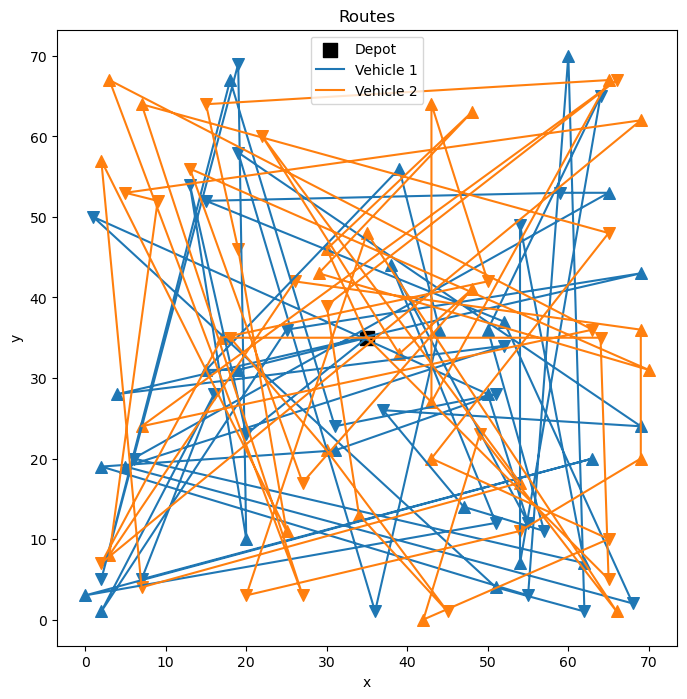

In [117]:
plot_routes(instance, routes)

In [121]:
get_total_distance(instance, routes[0])

2128

In [122]:
objective_function(instance,routes)

4158.014401640645

In [123]:
get_Jain_fairness(instance, routes)

0.9994448095356795